# 월간 데이콘 예술 작품 화가 분류 AI 경진대회

- 전이학습(EfficientNetB0) 활용
- 학습용 이미지: 원본 + 1/2 + 1/4 image slicing 활용

In [2]:
import os
import tensorflow as tf

import numpy as np
import random
import pandas as pd
import image_slicer
import glob
from PIL import Image

from sklearn import preprocessing
from sklearn.metrics import f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import warnings

In [3]:
# 경고창 제거
warnings.filterwarnings(action='ignore')

# 그래프 스타일 설정
plt.style.use('fivethirtyeight')

# 결과값 출력 옵션 설정
pd.set_option('max_colwidth', 200)

In [4]:
# Python Version 확인
import sys
print("--sys.version(Python Version)—")
print(sys.version)

# Tensorflow Version 확인
print("\n--Tensorflow Version—")
print(tf.__version__)

--sys.version(Python Version)—
3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0]

--Tensorflow Version—
2.9.1


In [5]:
# SEED 고정
SEED = 41
tf.random.set_seed(SEED)

In [6]:
# train/test data 불러오기
train_df = pd.read_csv('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train.csv')
test_df = pd.read_csv('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test.csv')

In [7]:
# 문제 오류 수정

# id = 3896
train_df.iloc[3896,2] = 'Titian'

# id = 3986
train_df.iloc[3986,0] = 3986
train_df.iloc[3986,1] = './train/3986.jpg'
train_df.iloc[3986,2] = 'Alfred Sisley'

# Data Preprocessing

In [8]:
# Train data 확인/전처리
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [9]:
# Train data 확인/전처리
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [10]:
# img_path(경로 및 파일명) 수정
train_df['img_path'] = train_df['img_path'].str.replace('./train', '/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train')

# 경로 및 파일 + 화가 컬럼만 불러와서 최종 데이터셋 구성
train_df = train_df[['img_path', 'artist']]

# 최종 train_df 확인
train_df.head()

,img_path,artist
0,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0000.jpg,Diego Velazquez
1,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0001.jpg,Vincent van Gogh
2,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0002.jpg,Claude Monet
3,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0003.jpg,Edgar Degas
4,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0004.jpg,Hieronymus Bosch


In [11]:
# Test data 확인/전처리
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [12]:
# img_path(경로 및 파일명) 수정
test_df['img_path'] = test_df['img_path'].str.replace('./test', '/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test')

# 최종 test_df 확인
test_df.head()

,id,img_path
0,TEST_00000,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test/TEST_00000.jpg
1,TEST_00001,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test/TEST_00001.jpg
2,TEST_00002,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test/TEST_00002.jpg
3,TEST_00003,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test/TEST_00003.jpg
4,TEST_00004,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/test/TEST_00004.jpg


Image Slicing

In [13]:
# # Train data image n분할 및 새 폴더에 저장
# def image_slicing(df, slice):
#     # slice 수에 맞는 폴더 생성
#     os.mkdir('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_{0}slices'.format(str(slice)))
    
#     for i in range(len(train_df)):
#         filename = train_df['img_path'][i][-8:-4] # 0000부터 시작하는 파일이름 변수로 저장

#         tiles = image_slicer.slice(train_df['img_path'][i], slice, save=False)
#         image_slicer.save_tiles(tiles, prefix=filename, 
#                                 directory='/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_{0}slices'.format(str(slice)), 
#                                 format='jpeg'
#                                )

In [14]:
# # 2분할, 4분할 image 생성
# image_slicing(train_df, 2)
# image_slicing(train_df, 4)

In [15]:
# 디렉토리 내 파일 개수 확인
print('파일 갯수(2slices):', len(os.listdir('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_2slices')))
print('파일 갯수(4slices):', len(os.listdir('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices')))

파일 갯수(2slices): 11822
파일 갯수(4slices): 23644


In [16]:
# 폴더에 저장된 sliced image -> list로 저장
images_2slices = glob.glob('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_2slices/*')
images_4slices = glob.glob('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/*')

In [17]:
# 파일 이름 오름차순 정렬
images_2slices.sort()
images_4slices.sort()

In [18]:
# 2분할, 4분할 이미지 1개의 list로 합치기
sliced_images = images_2slices + images_4slices

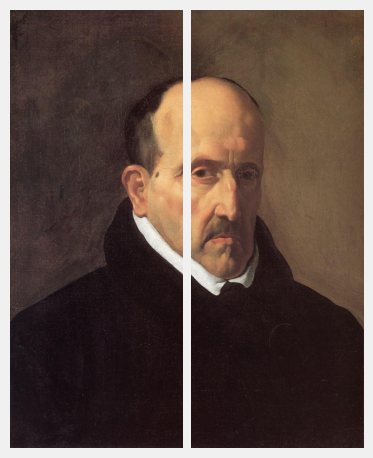

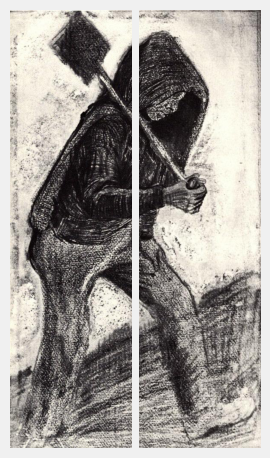

In [19]:
# 2분할된 이미지 정렬 확인 및 시각화
for i in range(2):
  plt.subplot(1,2,i+1)
  image = Image.open(images_2slices[i])
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=-7)
plt.show()

for i in range(2):
  plt.subplot(1,2,i+1)
  image = Image.open(images_2slices[i+2])
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=-10)
plt.show()  

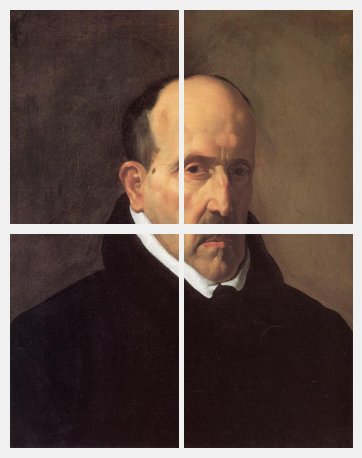

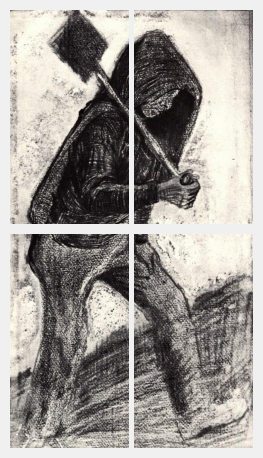

In [20]:
# 4분할된 이미지 정렬 확인 및 시각화
for i in range(4):
  plt.subplot(2,2,i+1)
  image = Image.open(images_4slices[i])
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=-7)
plt.show()

for i in range(4):
  plt.subplot(2,2,i+1)
  image = Image.open(images_4slices[i+4])
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=-10)
plt.show() 

In [21]:
# Sliced image에 맞는 Label(Artist) 추가
original_label = train_df['artist'].tolist()
len(original_label)

5911

In [22]:
# 분할된 이미지에 대한 Label 생성 -> 기존 Label 4회 반복
labels_2slices = []
labels_4slices = []

for i in range(len(original_label)):
  for j in range(2):
      labels_2slices.append(original_label[i])
        
for i in range(len(original_label)):
  for j in range(4):
      labels_4slices.append(original_label[i])

In [23]:
labels_2slices[0:12]

['Diego Velazquez',
 'Diego Velazquez',
 'Vincent van Gogh',
 'Vincent van Gogh',
 'Claude Monet',
 'Claude Monet',
 'Edgar Degas',
 'Edgar Degas',
 'Hieronymus Bosch',
 'Hieronymus Bosch',
 'Pierre-Auguste Renoir',
 'Pierre-Auguste Renoir']

In [24]:
labels_4slices[0:24]

['Diego Velazquez',
 'Diego Velazquez',
 'Diego Velazquez',
 'Diego Velazquez',
 'Vincent van Gogh',
 'Vincent van Gogh',
 'Vincent van Gogh',
 'Vincent van Gogh',
 'Claude Monet',
 'Claude Monet',
 'Claude Monet',
 'Claude Monet',
 'Edgar Degas',
 'Edgar Degas',
 'Edgar Degas',
 'Edgar Degas',
 'Hieronymus Bosch',
 'Hieronymus Bosch',
 'Hieronymus Bosch',
 'Hieronymus Bosch',
 'Pierre-Auguste Renoir',
 'Pierre-Auguste Renoir',
 'Pierre-Auguste Renoir',
 'Pierre-Auguste Renoir']

In [25]:
# label 합치기
sliced_labels = labels_2slices + labels_4slices

In [26]:
# 분할된 이미지에 대한 데이터프레임 생성
train_sliced_df = pd.DataFrame({'img_path':sliced_images, 'artist':sliced_labels})
train_sliced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35466 entries, 0 to 35465
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  35466 non-null  object
 1   artist    35466 non-null  object
dtypes: object(2)
memory usage: 554.3+ KB


In [27]:
# 기존 Original train_df와 합쳐서 최종 dataset 생성
train_final_df = pd.concat([train_df, train_sliced_df])
train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41377 entries, 0 to 35465
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  41377 non-null  object
 1   artist    41377 non-null  object
dtypes: object(2)
memory usage: 969.8+ KB


In [28]:
train_final_df.head(20)

,img_path,artist
0,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0000.jpg,Diego Velazquez
1,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0001.jpg,Vincent van Gogh
2,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0002.jpg,Claude Monet
3,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0003.jpg,Edgar Degas
4,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0004.jpg,Hieronymus Bosch
5,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0005.jpg,Pierre-Auguste Renoir
6,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0006.jpg,Rene Magritte
7,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0007.jpg,Rene Magritte
8,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0008.jpg,Michelangelo
9,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train/0009.jpg,Peter Paul Rubens


In [29]:
train_final_df.tail(20)

,img_path,artist
35446,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5906_01_01.jpg,Pieter Bruegel
35447,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5906_01_02.jpg,Pieter Bruegel
35448,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5906_02_01.jpg,Pieter Bruegel
35449,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5906_02_02.jpg,Pieter Bruegel
35450,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5907_01_01.jpg,Peter Paul Rubens
35451,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5907_01_02.jpg,Peter Paul Rubens
35452,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5907_02_01.jpg,Peter Paul Rubens
35453,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5907_02_02.jpg,Peter Paul Rubens
35454,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5908_01_01.jpg,Paul Gauguin
35455,/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/train_4slices/5908_01_02.jpg,Paul Gauguin


# Data Generation

In [30]:
# 기본 parameter 설정
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
epochs = 100
batch_size = 32
learning_rate = 0.0003
dropout_rate = 0.4

Data Augmentation

In [31]:
datagen = ImageDataGenerator(
    # rescale=1./255,          
    validation_split=0.15,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    # shear_range=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.5,
    # rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True
)

In [32]:
train_data = datagen.flow_from_dataframe(
    train_final_df, 
    x_col='img_path', 
    y_col='artist', 
    target_size=target_size, 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=batch_size, 
    shuffle=True, 
    subset='training')

val_data = datagen.flow_from_dataframe(
    train_final_df, 
    x_col='img_path', 
    y_col='artist', 
    target_size=target_size, 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=batch_size, 
    shuffle=True, 
    subset='validation')

Found 35171 validated image filenames belonging to 50 classes.
Found 6206 validated image filenames belonging to 50 classes.


In [33]:
# Class 분류 및 Label Encoding 확인
train_data.class_indices

{'Albrecht Du rer': 0,
 'Alfred Sisley': 1,
 'Amedeo Modigliani': 2,
 'Andrei Rublev': 3,
 'Andy Warhol': 4,
 'Camille Pissarro': 5,
 'Caravaggio': 6,
 'Claude Monet': 7,
 'Diego Rivera': 8,
 'Diego Velazquez': 9,
 'Edgar Degas': 10,
 'Edouard Manet': 11,
 'Edvard Munch': 12,
 'El Greco': 13,
 'Eugene Delacroix': 14,
 'Francisco Goya': 15,
 'Frida Kahlo': 16,
 'Georges Seurat': 17,
 'Giotto di Bondone': 18,
 'Gustav Klimt': 19,
 'Gustave Courbet': 20,
 'Henri Matisse': 21,
 'Henri Rousseau': 22,
 'Henri de Toulouse-Lautrec': 23,
 'Hieronymus Bosch': 24,
 'Jackson Pollock': 25,
 'Jan van Eyck': 26,
 'Joan Miro': 27,
 'Kazimir Malevich': 28,
 'Leonardo da Vinci': 29,
 'Marc Chagall': 30,
 'Michelangelo': 31,
 'Mikhail Vrubel': 32,
 'Pablo Picasso': 33,
 'Paul Cezanne': 34,
 'Paul Gauguin': 35,
 'Paul Klee': 36,
 'Peter Paul Rubens': 37,
 'Pierre-Auguste Renoir': 38,
 'Piet Mondrian': 39,
 'Pieter Bruegel': 40,
 'Raphael': 41,
 'Rembrandt': 42,
 'Rene Magritte': 43,
 'Salvador Dali': 44,


# Modeling 

In [34]:
# imagenet 가중치 활용 + 파라미터 학습 X
transfer_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
transfer_model.trainable=True

transfer_model.summary()

2022-11-06 23:40:59.159908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 23:40:59.162661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 23:40:59.162830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 23:40:59.163143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [35]:
model = Sequential([
                    transfer_model,
                    GlobalAveragePooling2D(),
                    Dropout(rate=dropout_rate),
                    Dense(50, activation="softmax")
                  ])

# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 50)                64050     
                                                                 
Total params: 4,113,621
Trainable params: 4,071,598
Non-trainable params: 42,023
_________________________________________________________________


In [36]:
# Precision, Recall, F1 score 변수 정의

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [38]:
# 모델 Compile
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', f1score]
             )

In [39]:
# 조기 종료, Checkpoint, 학습률 조정 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(filepath='/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/model/DACON_Artist_EfficientNet_12.hdf5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   # save_weights_only=True,
                                   verbose=1
                                  )

rl = ReduceLROnPlateau(patience=5, verbose=1, min_lr=0.00001, factor=0.3)

In [38]:
# 모델 Fitting
history = model.fit(train_data, 
                    epochs=epochs, 
                    batch_size=batch_size,  
                    callbacks=[early_stopping, model_checkpoint, rl],
                    validation_data=val_data
                    )

Epoch 1/100


2022-11-03 08:28:21.058152: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-03 08:28:22.001792: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1100/1100 [==============================] - ETA: 0s - loss: 1.4678 - accuracy: 0.6038 - f1score: 0.6366
Epoch 1: val_loss improved from inf to 0.78838, saving model to /home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/model/DACON_Artist_EfficientNet_12.hdf5
1100/1100 [==============================] - 196s 173ms/step - loss: 1.4678 - accuracy: 0.6038 - f1score: 0.6366 - val_loss: 0.7884 - val_accuracy: 0.7680 - val_f1score: 0.8749 - lr: 3.0000e-04
Epoch 2/100
1100/1100 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.8131 - f1score: 0.8840
Epoch 2: val_loss improved from 0.78838 to 0.35357, saving model to /home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/model/DACON_Artist_EfficientNet_12.hdf5
1100/1100 [==============================] - 188s 171ms/step - loss: 0.6305 - accuracy: 0.8131 - f1score: 0.8840 - val_loss: 0.3536 - val_accuracy: 0.8879 - val_f1score: 0.9407 - lr: 3.0000e-04
Epoch 3/100
1100/1100 [==============================] - ETA: 0s - loss: 0.4085 - 

1100/1100 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9984 - f1score: 0.9805
Epoch 41: val_loss improved from 0.03996 to 0.03958, saving model to /home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/model/DACON_Artist_EfficientNet_12.hdf5
1100/1100 [==============================] - 188s 171ms/step - loss: 0.0053 - accuracy: 0.9984 - f1score: 0.9805 - val_loss: 0.0396 - val_accuracy: 0.9866 - val_f1score: 0.9794 - lr: 2.7000e-05
Epoch 42/100
1100/1100 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9986 - f1score: 0.9807
Epoch 42: val_loss did not improve from 0.03958
1100/1100 [==============================] - 188s 170ms/step - loss: 0.0046 - accuracy: 0.9986 - f1score: 0.9807 - val_loss: 0.0424 - val_accuracy: 0.9873 - val_f1score: 0.9792 - lr: 2.7000e-05
Epoch 43/100
1100/1100 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9987 - f1score: 0.9805
Epoch 43: val_loss did not improve from 0.03958
1100/1100 [=======

Epoch 62/100
1100/1100 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9992 - f1score: 0.9808
Epoch 62: val_loss did not improve from 0.03160
1100/1100 [==============================] - 190s 173ms/step - loss: 0.0031 - accuracy: 0.9992 - f1score: 0.9808 - val_loss: 0.0319 - val_accuracy: 0.9884 - val_f1score: 0.9794 - lr: 1.0000e-05
Epoch 63/100
1100/1100 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993 - f1score: 0.9808
Epoch 63: val_loss did not improve from 0.03160
1100/1100 [==============================] - 191s 174ms/step - loss: 0.0025 - accuracy: 0.9993 - f1score: 0.9808 - val_loss: 0.0344 - val_accuracy: 0.9882 - val_f1score: 0.9795 - lr: 1.0000e-05
Epoch 64/100
1100/1100 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993 - f1score: 0.9808
Epoch 64: val_loss did not improve from 0.03160
1100/1100 [==============================] - 190s 173ms/step - loss: 0.0025 - accuracy: 0.9993 - f1score: 0.9808 -

# Model Evaluation

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1score = history.history['f1score']
val_f1score = history.history['val_f1score']

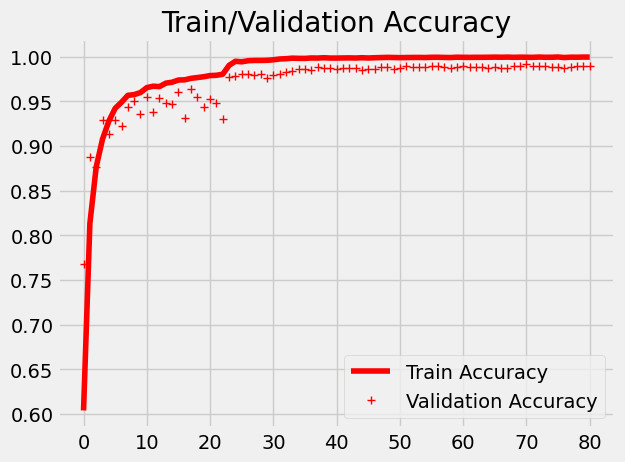

In [40]:
# Accuracy 시각화
plt.plot(accuracy, 'r-', label='Train Accuracy')
plt.plot(val_accuracy, 'r+', label='Validation Accuracy')
plt.title('Train/Validation Accuracy')
plt.legend(loc='best')
plt.show()

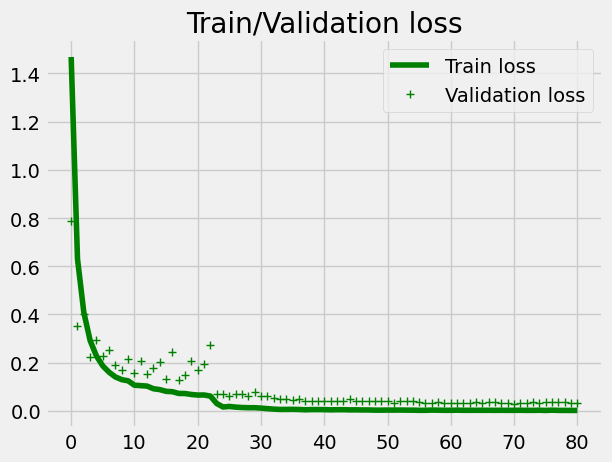

In [41]:
# loss 시각화
plt.plot(loss, 'g-', label='Train loss')
plt.plot(val_loss, 'g+', label='Validation loss')
plt.title('Train/Validation loss')
plt.legend(loc='best')
plt.show()

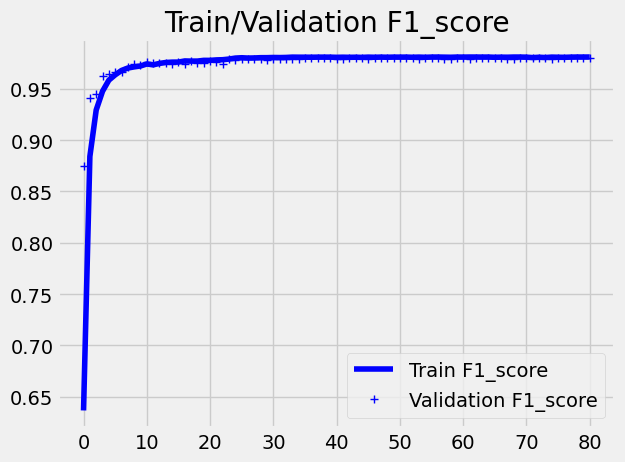

In [42]:
# f1 score 시각화
plt.plot(f1score, 'b-', label='Train F1_score')
plt.plot(val_f1score, 'b+', label='Validation F1_score')
plt.title('Train/Validation F1_score')
plt.legend(loc='best')
plt.show()

In [41]:
# Best model 불러오기
model = tf.keras.models.load_model('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/model/DACON_Artist_EfficientNet_12.hdf5', custom_objects = {'f1score' : f1score})

In [42]:
# Prediction을 위한 Test data 생성
test_datagen = ImageDataGenerator(
                                # rescale=1./255
)

test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col='img_path',
    target_size=target_size,
    color_mode='rgb', 
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 12670 validated image filenames.


In [43]:
# 예측값 생성
pred_values = model.predict(test_data)

2022-11-06 23:45:23.927744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  3/396 [..............................] - ETA: 23s  

2022-11-06 23:45:24.821045: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


396/396 [==============================] - 43s 103ms/step


In [44]:
# 가장 높은 확률로 예측한 값의 Index 추출
pred_list = []

for value in pred_values:
    pred_list.append(value.argmax())

In [45]:
# Label -> 원본(Artist 이름)으로 변환
artist_dict = train_data.class_indices
artist_dict

{'Albrecht Du rer': 0,
 'Alfred Sisley': 1,
 'Amedeo Modigliani': 2,
 'Andrei Rublev': 3,
 'Andy Warhol': 4,
 'Camille Pissarro': 5,
 'Caravaggio': 6,
 'Claude Monet': 7,
 'Diego Rivera': 8,
 'Diego Velazquez': 9,
 'Edgar Degas': 10,
 'Edouard Manet': 11,
 'Edvard Munch': 12,
 'El Greco': 13,
 'Eugene Delacroix': 14,
 'Francisco Goya': 15,
 'Frida Kahlo': 16,
 'Georges Seurat': 17,
 'Giotto di Bondone': 18,
 'Gustav Klimt': 19,
 'Gustave Courbet': 20,
 'Henri Matisse': 21,
 'Henri Rousseau': 22,
 'Henri de Toulouse-Lautrec': 23,
 'Hieronymus Bosch': 24,
 'Jackson Pollock': 25,
 'Jan van Eyck': 26,
 'Joan Miro': 27,
 'Kazimir Malevich': 28,
 'Leonardo da Vinci': 29,
 'Marc Chagall': 30,
 'Michelangelo': 31,
 'Mikhail Vrubel': 32,
 'Pablo Picasso': 33,
 'Paul Cezanne': 34,
 'Paul Gauguin': 35,
 'Paul Klee': 36,
 'Peter Paul Rubens': 37,
 'Pierre-Auguste Renoir': 38,
 'Piet Mondrian': 39,
 'Pieter Bruegel': 40,
 'Raphael': 41,
 'Rembrandt': 42,
 'Rene Magritte': 43,
 'Salvador Dali': 44,


In [46]:
# Key value swap
artist_dict = {value:key for key, value in artist_dict.items()}
artist_dict

{0: 'Albrecht Du rer',
 1: 'Alfred Sisley',
 2: 'Amedeo Modigliani',
 3: 'Andrei Rublev',
 4: 'Andy Warhol',
 5: 'Camille Pissarro',
 6: 'Caravaggio',
 7: 'Claude Monet',
 8: 'Diego Rivera',
 9: 'Diego Velazquez',
 10: 'Edgar Degas',
 11: 'Edouard Manet',
 12: 'Edvard Munch',
 13: 'El Greco',
 14: 'Eugene Delacroix',
 15: 'Francisco Goya',
 16: 'Frida Kahlo',
 17: 'Georges Seurat',
 18: 'Giotto di Bondone',
 19: 'Gustav Klimt',
 20: 'Gustave Courbet',
 21: 'Henri Matisse',
 22: 'Henri Rousseau',
 23: 'Henri de Toulouse-Lautrec',
 24: 'Hieronymus Bosch',
 25: 'Jackson Pollock',
 26: 'Jan van Eyck',
 27: 'Joan Miro',
 28: 'Kazimir Malevich',
 29: 'Leonardo da Vinci',
 30: 'Marc Chagall',
 31: 'Michelangelo',
 32: 'Mikhail Vrubel',
 33: 'Pablo Picasso',
 34: 'Paul Cezanne',
 35: 'Paul Gauguin',
 36: 'Paul Klee',
 37: 'Peter Paul Rubens',
 38: 'Pierre-Auguste Renoir',
 39: 'Piet Mondrian',
 40: 'Pieter Bruegel',
 41: 'Raphael',
 42: 'Rembrandt',
 43: 'Rene Magritte',
 44: 'Salvador Dali',


In [47]:
# Label을 Key값에 맞는 arist로 변환
pred_artist = []

for label in pred_list:
    for key, value in artist_dict.items():
        if key == label:
            pred_artist.append(value)

In [48]:
pred_artist[:5]

['Edgar Degas',
 'Amedeo Modigliani',
 'Caravaggio',
 'Albrecht Du rer',
 'Edgar Degas']

In [49]:
# Submission 파일 생성
submission = pd.read_csv('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/dataset/sample_submission.csv')
submission.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Edgar Degas
2,TEST_00002,Edgar Degas
3,TEST_00003,Edgar Degas
4,TEST_00004,Edgar Degas


In [50]:
submission['artist'] = pred_artist
submission.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Caravaggio
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Edgar Degas


In [51]:
submission.to_csv('/home/notebook/DACON/월간 데이콘 예술 작품 화가 분류 AI 경진대회/result/submission(EfficientNet_12)_221107_AJH.csv', index=False)